In [ ]:
import wfdb
import glob
import os
import re
import csv
import numpy as np

def label(filename):
    match = re.match(r"p(\d+)(c?)-?", filename)
    if not match:
        return ValueError(f"Filename: {filename} format is not recognized.")

    number = int(match.group(1))
    has_c = 'c' in match.group(2)
    if number % 2 ==1:
        if has_c: 
            return [1, 0, 0]
        else:
            return [0, 1, 0]
    else:
        return [0, 0, 1]

def segment(dir, file, save_dir, csv_rows, label_vector, window_size=30, overlap=0.0):
    try:
        pathname = os.path.join(dir, file)
        record = wfdb.rdrecord(pathname)
        signal = record.p_signal[:, 0]  
        fs = record.fs
        window = int(window_size * fs)
        step = int(window * (1 - overlap))
        os.makedirs(save_dir, exist_ok=True)
        segement_id = 0
        for start in range(0, len(signal) - window + 1, step):
            segment = signal[start:start + window]
            segment_filename = f"{os.path.basename(file)}_{segement_id}.npy"
            segment_path = os.path.join(save_dir, segment_filename)
            np.save(segment_path, segment)
            csv_rows.append([segment_filename] + label_vector)
            segement_id += 1
    except Exception as e:
        print(f"Error reading {pathname}: {e}")
        return

def label_and_segment_files(dir, files, save_dir, csv_rows,window_size=30, overlap=0.0):
    csv_rows.append(['filename', 'AF', 'Pre-AF', 'SR'])
    for file in files:
        filename = os.path.basename(file)
        label_vector = label(filename)
        segment(dir, file, save_dir, csv_rows, label_vector, window_size, overlap)
    return csv_rows

dir = '/Users/weijithwimalasiri/Desktop/JustForFun/RPS/physionet.org/files/afpdb/1.0.0'

hea_files = sorted(glob.glob(os.path.join(dir, 'p*.hea')))
record_names = [os.path.splitext(os.path.basename(f))[0] for f in hea_files]

csv_rows = []
save_dir = os.path.join(dir, 'segments')
csv_rows = label_and_segment_files(dir, record_names, save_dir, csv_rows, window_size=30, overlap=0.0)
output_csv = os.path.join(save_dir, 'labels.csv')
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(csv_rows)
print(f"Labels and segments saved to {output_csv}")

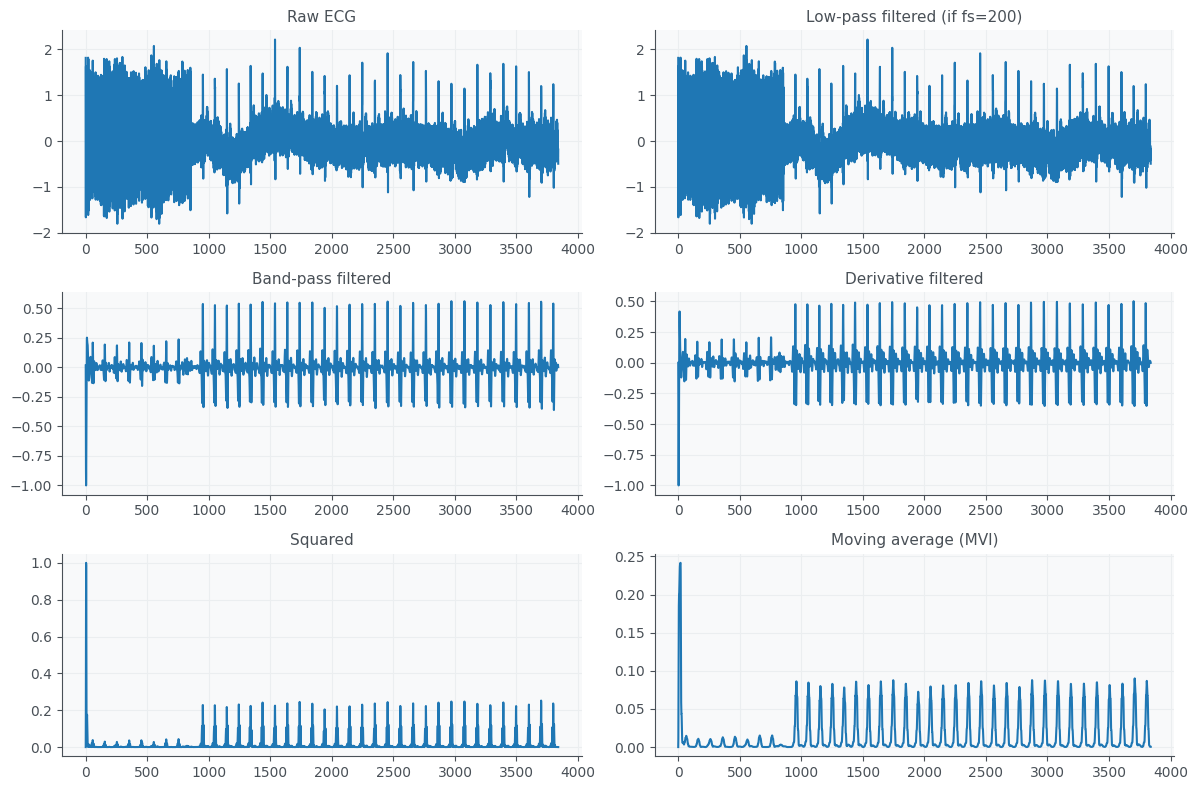

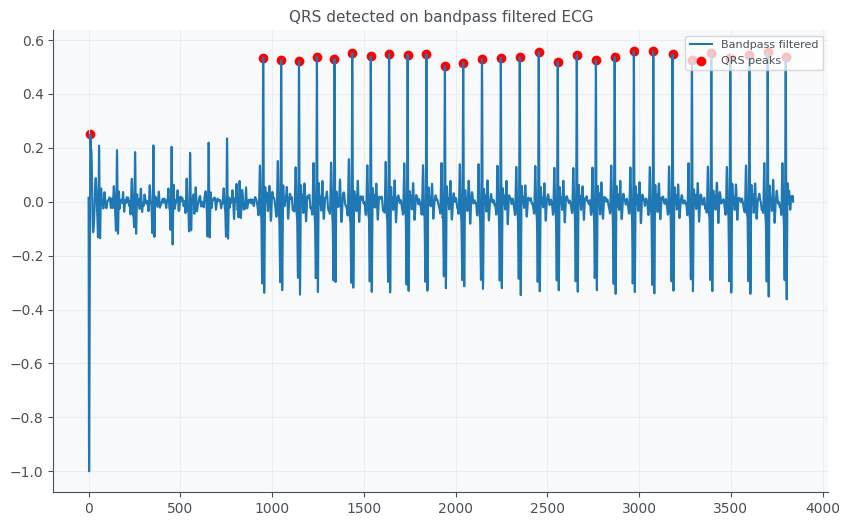

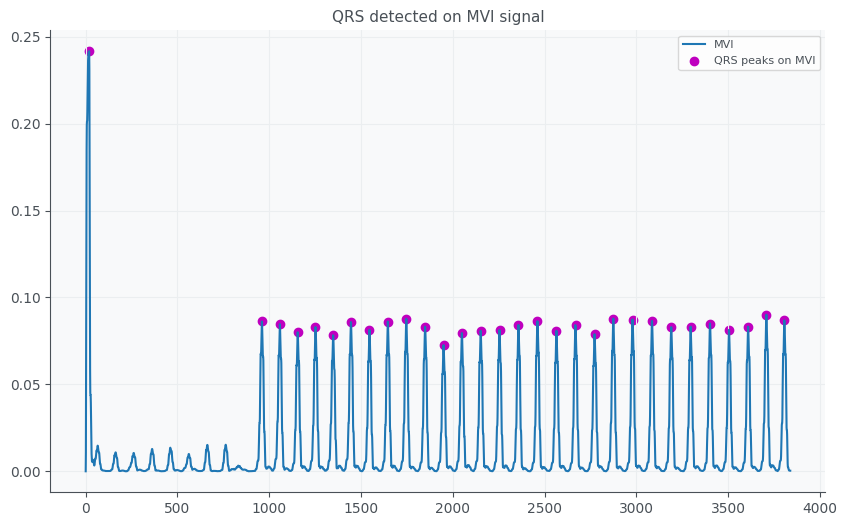

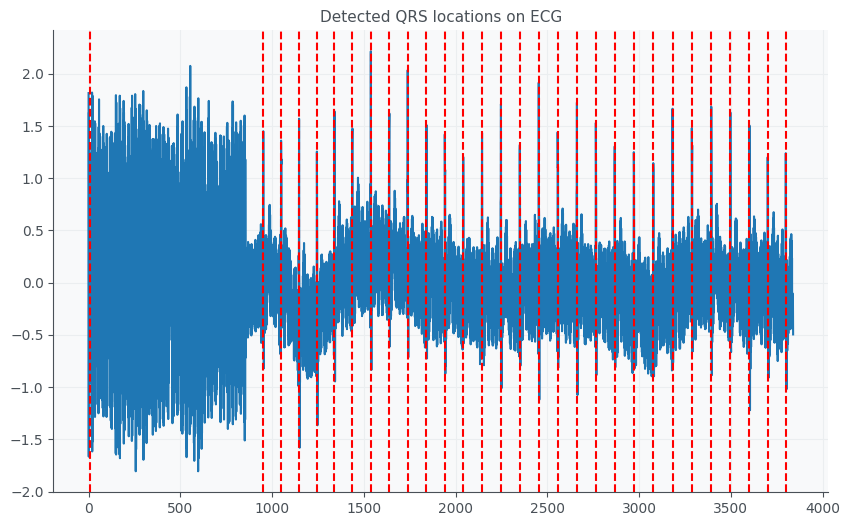

Detected 30 QRS complexes.
QRS Amplitudes: [0.2498265  0.53477232 0.52481952 0.52171631 0.53748999 0.52967126
 0.55190692 0.54007481 0.54764793 0.54505527 0.5472955  0.50195928
 0.51603795 0.52882016 0.53414604 0.53551387 0.55496689 0.51871185
 0.54400934 0.52580021 0.53675292 0.55806277 0.55798279 0.54685082
 0.52557974 0.55009338 0.53340735 0.54336521 0.55374496 0.53806562]
QRS Indices: [  10  952 1050 1147 1244 1340 1437 1538 1638 1738 1841 1941 2041 2144
 2246 2349 2453 2556 2660 2764 2867 2971 3077 3182 3288 3393 3497 3601
 3700 3799]
Filtering delay (samples): 9


In [101]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, convolve
import matplotlib.pyplot as plt

def pan_tompkins(signal, fs, plot=False):
    ecg = np.ravel(signal) #Flatten to a 1D array
    delay = 0
    skip = False
    ser_back = False # Search-back mode: Triggered when a likely QRS peak is misses.

    ecg = ecg - np.mean(ecg)  # Remove DC offset

    # Bandpass filter
    if fs ==200: # Different because the Pan Tompkins algorithm is designed for 200Hz sampling rate
        # Low-pass filter(~12Hz cutoff)
        Wn_low = 12*2/fs # According to the Nyquist theorem
        b_low, a_low = butter(3, Wn_low, btype='lowpass') # Order 3 Butterworth filter 
        ecg_low = filtfilt(b_low, a_low, ecg) 
        ecg_low /= np.max(np.abs(ecg_low)) # Normalize the signal between -1 and 1 

        # High-pass filter(~5Hz cutoff)
        Wn_high = 5*2/fs
        b_high, a_high = butter(3, Wn_high, btype='highpass')
        ecg_high = filtfilt(b_high, a_high, ecg_low)
        ecg_high /= np.max(np.abs(ecg_high))
    
    else:
        f_high , f_low = 5, 15
        Wn = [f_high*2/fs, f_low*2/fs]
        b, a = butter(3, Wn, btype = 'bandpass')
        ecg_high = filtfilt(b, a, ecg)
        ecg_high /= np.max(np.abs(ecg_high))
    
    # Derivative filter
    if fs == 200:
        b_derivative = np.array([1,2,0,-2,-1]) * (1/8) * fs # 5-point derivative filter
    else:        
        x_old = np.arange(5)
        y_old = np.array([1,2,0,-2,-1]) * (1/8) * fs
        x_new = np.linspace(0, 4, int(fs / 40 * 4)) #Interpolate to stretch the filter at higher resolutiona
        b_derivative = np.interp(x_new, x_old, y_old)
    ecg_derivative = filtfilt(b_derivative, [1], ecg_high)
    ecg_derivative /= np.max(np.abs(ecg_derivative))  

    # Squaring
    ecg_squared = ecg_derivative ** 2

    # Moving window integration(MWI)
    window_size = int(round(0.150 * fs))
    ecg_mwi = convolve(ecg_squared, np.ones(window_size)/window_size, mode='full')[:len(ecg_squared)]
    delay += int(window_size / 2) 

    min_distance = int(round(0.2 * fs))  
    peaks, _ = find_peaks(ecg_mwi, distance=min_distance)

    LLp = len(peaks)
    qrs_amp = np.zeros(LLp) # Amplitudes of QRS peaks in the smoothed (MVI) signal.
    qrs_ind = np.zeros(LLp, dtype=int) # Indices of QRS peaks in the MVI signal.
    qrs_raw_amp = np.zeros(LLp)  # Amplitudes of QRS peaks in the bandpass filtered signal.
    qrs_raw_ind = np.zeros(LLp, dtype=int)  # Indices of QRS peaks in the bandpass filtered signal.

    noise_amp = np.zeros(LLp) # Amplitudes of peaks identified as noise (not true QRS).
    noise_ind = np.zeros(LLp, dtype=int)  # Indices of noise peaks. 

    SIGL_buf = np.zeros(LLp)  # Buffer for the signal levels in the MVI signal.
    NOISL_buf = np.zeros(LLp)  # Buffer for the noise levels in the MVI signal.
    SIGL_buf_raw = np.zeros(LLp)  # Buffer for the signal levels in the bandpass filtered signal.
    NOISL_buf_raw = np.zeros(LLp)  # Buffer for the noise
    THRS_buff = np.zeros(LLp)  # Buffer for the threshold levels.
    THRS_buff_raw = np.zeros(LLp)  # Buffer for the threshold levels in the bandpass filtered signal.

    THR_SIG = np.max(ecg_mwi[:2*fs]) / 3.0
    THR_NOISE = np.mean(ecg_mwi[:2*fs]) / 2.0
    SIG_LEV = THR_SIG
    NOISE_LEV = THR_NOISE

    THR_SIG1 = np.max(ecg_high[:2*fs])/3.0
    THR_NOISE1 = np.mean(ecg_high[:2*fs])/2.0
    SIG_LEV1 = THR_SIG1
    NOISE_LEV1 = THR_NOISE1

    Beats = 0 # # Count of QRS peaks from MWI signal
    Beats_raw = 0 # Count of QRS peaks from bandpass filtered signal
    Noise_Count = 0 # Number of peaks identified as noise
    mean_RR = 0 # Average interval of previous 8 QRS peaks.
    m_selected_RR = 0 # Final average RR used for detecting missed beats
    ser_back = False

    for i in range(LLp):
        loc = peaks[i]
        window_start = max(0, loc - window_size)
        window_end = loc
        if window_end > window_start:
            segment = ecg_high[window_start:window_end]
            y_i = np.max(segment) # high frequency component of the ECG signal
            x_i = np.argmax(segment) + window_start # index of the maximum in the segment
        else:
            y_i = ecg_high[loc]
            x_i = loc
        
        if Beats >= 9:
            diffRR = np.diff(qrs_ind[Beats-8:Beats])
            mean_RR = np.mean(diffRR) 
            comp = qrs_ind[Beats-1] - qrs_ind[Beats-2] if Beats > 1 else 0
            if comp != 0 and (comp <= 0.92 * mean_RR or comp >= 1.16 * mean_RR):
                THR_SIG *= 0.5
                THR_SIG1 *= 0.5
            else:
                m_selected_RR = mean_RR
        
        test_m = m_selected_RR if m_selected_RR != 0 else mean_RR if mean_RR != 0  else 0 # best available RR interval

        # Check if the current peak is a valid QRS peak
        if test_m and Beats > 0:
            if (loc - qrs_ind[Beats-1]) >= int(1.66 * test_m): # if the interval between the current and previous QRS peak is more than 1.66 times the average RR interval, it is a missed beat
                search_segment = ecg_mwi[qrs_ind[Beats-1] + int(0.2*fs):loc - int(0.2*fs)] # search for a missed beat in the segment between the previous QRS peak and the current one
                if len(search_segment) > 0:
                    local_max = np.argmax(search_segment)
                    loc_temp = qrs_ind[Beats-1] + int(0.2*fs) + local_max 
                    pks_temp = search_segment[local_max]
                    if pks_temp > THR_NOISE:
                        Beats += 1
                        if Beats >= len(qrs_ind):
                            break
                        qrs_amp[Beats-1] = pks_temp
                        qrs_ind[Beats-1] = loc_temp
                        w_start = max(0, loc_temp - window_size)
                        w_end = min(loc_temp, len(ecg_high))
                        segment2 = ecg_high[w_start:w_end]
                        if len(segment2) > 0:
                            y_i_t = np.max(segment2)
                            x_i_t = np.argmax(segment2) + w_start
                            if y_i_t > THR_NOISE1:
                                Beats_raw += 1
                                qrs_raw_amp[Beats_raw-1] = y_i_t
                                qrs_raw_ind[Beats_raw-1] = x_i_t
                                SIG_LEV1 = 0.25 * y_i_t + 0.75 * SIG_LEV1
                            SIG_LEV = 0.25 * pks_temp + 0.75 * SIG_LEV
        
        if ecg_mwi[loc] >= THR_SIG:
            if Beats >= 3:
                if (loc - qrs_ind[Beats-1]) <= int(0.36*fs): # To avoid double counting, check if the current peak is within 0.36 seconds of the previous QRS peak
                    slope1 = np.mean(np.diff(ecg_mwi[loc-int(0.075*fs):loc])) # Average slope leading up to the current peak
                    slope2 = np.mean(np.diff(ecg_mwi[qrs_ind[Beats-1]-int(0.075*fs):qrs_ind[Beats-1]])) # Avwerage slope leading up to the last detected peak
                    if np.abs(slope1) <= 0.5*np.abs(slope2): # if the slope is too shallow throw it as noise
                        Noise_Count += 1
                        if Noise_Count < LLp:
                            noise_amp[Noise_Count-1] = ecg_mwi[loc]
                            noise_ind[Noise_Count-1] = loc
                        skip = True
                        NOISE_LEV1 = 0.125*y_i + 0.875*NOISE_LEV1
                        NOISE_LEV = 0.125*ecg_mwi[loc] + 0.875*NOISE_LEV
                    else:
                        skip = False
            if not skip:
                Beats += 1
                if Beats > LLp:
                    break
                qrs_amp[Beats -1] = ecg_mwi[loc]
                qrs_ind[Beats -1] = loc

                if y_i >= THR_SIG1:
                    Beats_raw += 1
                    if Beats_raw > LLp:
                        break
                    qrs_raw_ind[Beats_raw -1] = x_i
                    qrs_raw_amp[Beats_raw -1] = y_i
                    SIG_LEV1 = 0.125 * y_i + 0.875 * SIG_LEV1
                SIG_LEV = 0.125 * ecg_mwi[loc] + 0.875 * SIG_LEV

        elif THR_NOISE <= ecg_mwi[loc] < THR_SIG:
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV
        else:
            Noise_Count += 1
            if Noise_Count < LLp:
                noise_amp[Noise_Count-1] = ecg_mwi[loc]
                noise_ind[Noise_Count-1] = loc
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV

        # Update thresholds
        THR_SIG = NOISE_LEV + 0.25 * np.abs(SIG_LEV - NOISE_LEV)
        THR_NOISE = 0.5 * THR_SIG

        THR_SIG1 = NOISE_LEV1 + 0.25 * np.abs(SIG_LEV1 - NOISE_LEV1)
        THR_NOISE1 = 0.5 * THR_SIG1

        SIGL_buf[i] = SIG_LEV
        NOISL_buf[i] = NOISE_LEV
        THRS_buff[i] = THR_SIG

        SIGL_buf_raw[i] = SIG_LEV1
        NOISL_buf_raw[i] = NOISE_LEV1
        THRS_buff_raw[i] = THR_SIG1

        skip = False
        ser_back = False
    # Trim to detected beats
    qrs_raw_ind = qrs_raw_ind[:Beats_raw]
    qrs_raw_amp = qrs_raw_amp[:Beats_raw]
    qrs_amp = qrs_amp[:Beats]
    qrs_ind = qrs_ind[:Beats]

    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(12, 8))
        axs[0, 0].plot(ecg)
        axs[0, 0].set_title("Raw ECG")
        axs[0, 1].plot(ecg_low if fs == 200 else ecg)
        axs[0, 1].set_title("Low-pass filtered (if fs=200)")

        axs[1, 0].plot(ecg_high)
        axs[1, 0].set_title("Band-pass filtered")
        axs[1, 1].plot(ecg_derivative)
        axs[1, 1].set_title("Derivative filtered")

        axs[2, 0].plot(ecg_squared)
        axs[2, 0].set_title("Squared")
        axs[2, 1].plot(ecg_mwi)
        axs[2, 1].set_title("Moving average (MVI)")

        plt.tight_layout()
        plt.show()

        # Plot QRS on filtered signals
        plt.figure(figsize=(10, 6))
        plt.plot(ecg_high, label="Bandpass filtered")
        plt.scatter(qrs_raw_ind, qrs_raw_amp, color='r', label="QRS peaks")
        plt.legend()
        plt.title("QRS detected on bandpass filtered ECG")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg_mwi, label="MVI")
        plt.scatter(qrs_ind, qrs_amp, color='m', label="QRS peaks on MVI")
        plt.legend()
        plt.title("QRS detected on MVI signal")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg - np.mean(ecg), label="ECG centered")
        for peak in qrs_raw_ind:
            plt.axvline(x=peak, color='r', linestyle='--')
        plt.title("Detected QRS locations on ECG")
        plt.show()

    return qrs_raw_amp, qrs_raw_ind, delay

ecg = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
qrs_raw_amp, qrs_raw_ind, delay = pan_tompkins(ecg, fs, plot=True)
print(f"Detected {len(qrs_raw_ind)} QRS complexes.")
print("QRS Amplitudes:", qrs_raw_amp)
print("QRS Indices:", qrs_raw_ind)
print("Filtering delay (samples):", delay)

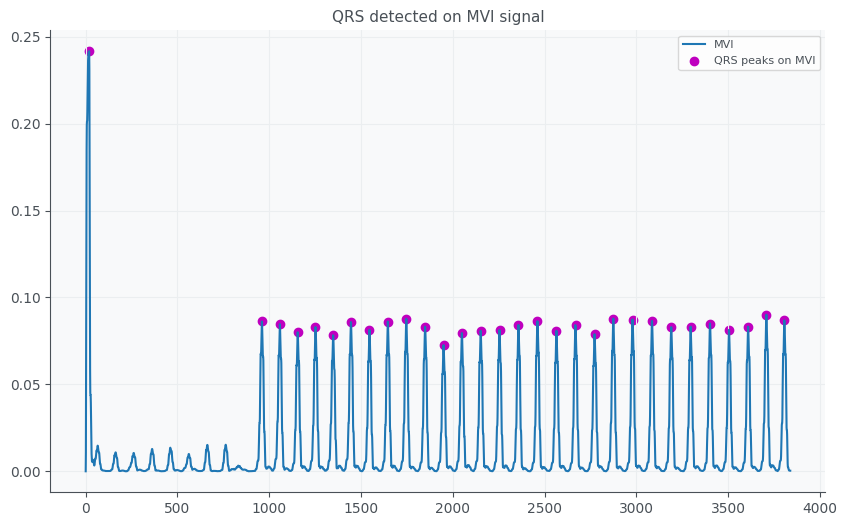

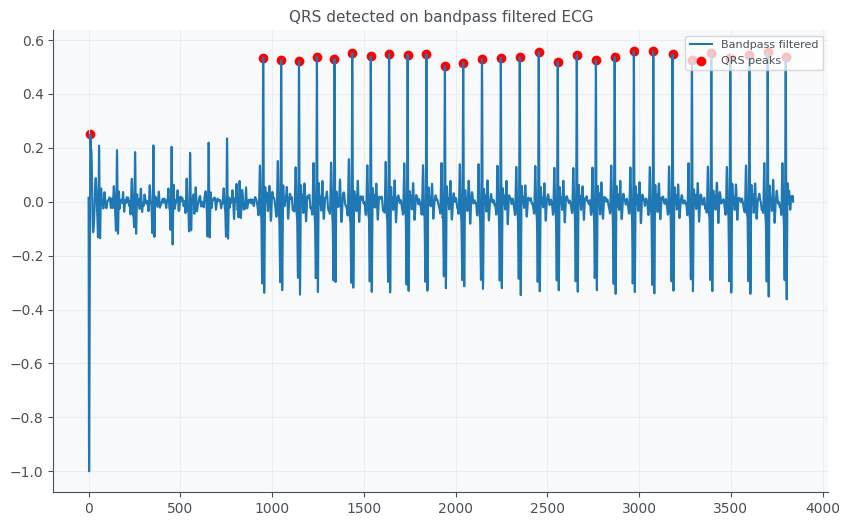

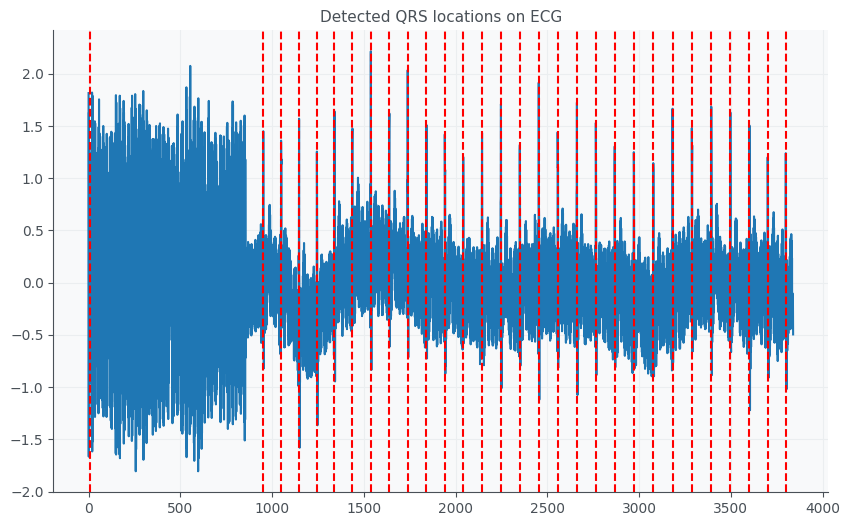

Detected 30 QRS complexes.
QRS Amplitudes: [0.2498265  0.53477232 0.52481952 0.52171631 0.53748999 0.52967126
 0.55190692 0.54007481 0.54764793 0.54505527 0.5472955  0.50195928
 0.51603795 0.52882016 0.53414604 0.53551387 0.55496689 0.51871185
 0.54400934 0.52580021 0.53675292 0.55806277 0.55798279 0.54685082
 0.52557974 0.55009338 0.53340735 0.54336521 0.55374496 0.53806562]
QRS Indices: [  10  952 1050 1147 1244 1340 1437 1538 1638 1738 1841 1941 2041 2144
 2246 2349 2453 2556 2660 2764 2867 2971 3077 3182 3288 3393 3497 3601
 3700 3799]
Filtering delay (samples): 9
R-R intervals (ms): [7359.375   765.625   757.8125  757.8125  750.      757.8125  789.0625
  781.25    781.25    804.6875  781.25    781.25    804.6875  796.875
  804.6875  812.5     804.6875  812.5     812.5     804.6875  812.5
  828.125   820.3125  828.125   820.3125  812.5     812.5     773.4375
  773.4375]


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, convolve
import matplotlib.pyplot as plt

def pan_tompkins(signal, fs, plot=False):
    ecg = np.ravel(signal)
    delay = 0
    skip = False
    ser_back = False

    ecg = ecg - np.mean(ecg)

    if fs == 200:
        Wn_low = 12 * 2 / fs
        b_low, a_low = butter(3, Wn_low, btype='lowpass')
        ecg_low = filtfilt(b_low, a_low, ecg)
        ecg_low /= np.max(np.abs(ecg_low))

        Wn_high = 5 * 2 / fs
        b_high, a_high = butter(3, Wn_high, btype='highpass')
        ecg_high = filtfilt(b_high, a_high, ecg_low)
        ecg_high /= np.max(np.abs(ecg_high))
    else:
        f_high, f_low = 5, 15
        Wn = [f_high * 2 / fs, f_low * 2 / fs]
        b, a = butter(3, Wn, btype='bandpass')
        ecg_high = filtfilt(b, a, ecg)
        ecg_high /= np.max(np.abs(ecg_high))

    if fs == 200:
        b_derivative = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
    else:
        x_old = np.arange(5)
        y_old = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
        x_new = np.linspace(0, 4, int(fs / 40 * 4))
        b_derivative = np.interp(x_new, x_old, y_old)

    ecg_derivative = filtfilt(b_derivative, [1], ecg_high)
    ecg_derivative /= np.max(np.abs(ecg_derivative))

    ecg_squared = ecg_derivative ** 2

    window_size = int(round(0.150 * fs))
    ecg_mwi = convolve(ecg_squared, np.ones(window_size) / window_size, mode='full')[:len(ecg_squared)]
    delay += int(window_size / 2)

    min_distance = int(round(0.2 * fs))
    peaks, _ = find_peaks(ecg_mwi, distance=min_distance)

    LLp = len(peaks)
    qrs_amp = np.zeros(LLp)
    qrs_ind = np.zeros(LLp, dtype=int)
    qrs_raw_amp = np.zeros(LLp)
    qrs_raw_ind = np.zeros(LLp, dtype=int)
    noise_amp = np.zeros(LLp)
    noise_ind = np.zeros(LLp, dtype=int)

    THR_SIG = np.max(ecg_mwi[:2 * fs]) / 3.0
    THR_NOISE = np.mean(ecg_mwi[:2 * fs]) / 2.0
    SIG_LEV = THR_SIG
    NOISE_LEV = THR_NOISE

    THR_SIG1 = np.max(ecg_high[:2 * fs]) / 3.0
    THR_NOISE1 = np.mean(ecg_high[:2 * fs]) / 2.0
    SIG_LEV1 = THR_SIG1
    NOISE_LEV1 = THR_NOISE1

    Beats = 0
    Beats_raw = 0
    Noise_Count = 0
    mean_RR = 0
    m_selected_RR = 0

    for i in range(LLp):
        loc = peaks[i]
        window_start = max(0, loc - window_size)
        window_end = loc
        segment = ecg_high[window_start:window_end] if window_end > window_start else ecg_high[loc:loc+1]
        y_i = np.max(segment)
        x_i = np.argmax(segment) + window_start if len(segment) > 1 else loc

        if Beats >= 9:
            diffRR = np.diff(qrs_ind[Beats - 8:Beats])
            mean_RR = np.mean(diffRR)
            comp = qrs_ind[Beats - 1] - qrs_ind[Beats - 2] if Beats > 1 else 0
            if comp != 0 and (comp <= 0.92 * mean_RR or comp >= 1.16 * mean_RR):
                THR_SIG *= 0.5
                THR_SIG1 *= 0.5
            else:
                m_selected_RR = mean_RR

        test_m = m_selected_RR if m_selected_RR != 0 else mean_RR if mean_RR != 0 else 0

        if test_m and Beats > 0:
            if (loc - qrs_ind[Beats - 1]) >= int(1.66 * test_m):
                search_segment = ecg_mwi[qrs_ind[Beats - 1] + int(0.2 * fs):loc - int(0.2 * fs)]
                if len(search_segment) > 0:
                    local_max = np.argmax(search_segment)
                    loc_temp = qrs_ind[Beats - 1] + int(0.2 * fs) + local_max
                    pks_temp = search_segment[local_max]
                    if pks_temp > THR_NOISE:
                        Beats += 1
                        if Beats >= len(qrs_ind): break
                        qrs_amp[Beats - 1] = pks_temp
                        qrs_ind[Beats - 1] = loc_temp
                        w_start = max(0, loc_temp - window_size)
                        w_end = min(loc_temp, len(ecg_high))
                        segment2 = ecg_high[w_start:w_end]
                        if len(segment2) > 0:
                            y_i_t = np.max(segment2)
                            x_i_t = np.argmax(segment2) + w_start
                            if y_i_t > THR_NOISE1:
                                Beats_raw += 1
                                qrs_raw_amp[Beats_raw - 1] = y_i_t
                                qrs_raw_ind[Beats_raw - 1] = x_i_t
                                SIG_LEV1 = 0.25 * y_i_t + 0.75 * SIG_LEV1
                            SIG_LEV = 0.25 * pks_temp + 0.75 * SIG_LEV

        if ecg_mwi[loc] >= THR_SIG:
            if Beats >= 3 and (loc - qrs_ind[Beats - 1]) <= int(0.36 * fs):
                slope1 = np.mean(np.diff(ecg_mwi[loc - int(0.075 * fs):loc]))
                slope2 = np.mean(np.diff(ecg_mwi[qrs_ind[Beats - 1] - int(0.075 * fs):qrs_ind[Beats - 1]]))
                if np.abs(slope1) <= 0.5 * np.abs(slope2):
                    Noise_Count += 1
                    if Noise_Count < LLp:
                        noise_amp[Noise_Count - 1] = ecg_mwi[loc]
                        noise_ind[Noise_Count - 1] = loc
                    skip = True
                    NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
                    NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV
                else:
                    skip = False
            if not skip:
                Beats += 1
                if Beats > LLp: break
                qrs_amp[Beats - 1] = ecg_mwi[loc]
                qrs_ind[Beats - 1] = loc
                if y_i >= THR_SIG1:
                    Beats_raw += 1
                    if Beats_raw > LLp: break
                    qrs_raw_ind[Beats_raw - 1] = x_i
                    qrs_raw_amp[Beats_raw - 1] = y_i
                    SIG_LEV1 = 0.125 * y_i + 0.875 * SIG_LEV1
                SIG_LEV = 0.125 * ecg_mwi[loc] + 0.875 * SIG_LEV
        elif THR_NOISE <= ecg_mwi[loc] < THR_SIG:
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV
        else:
            Noise_Count += 1
            if Noise_Count < LLp:
                noise_amp[Noise_Count - 1] = ecg_mwi[loc]
                noise_ind[Noise_Count - 1] = loc
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV

        THR_SIG = NOISE_LEV + 0.25 * np.abs(SIG_LEV - NOISE_LEV)
        THR_NOISE = 0.5 * THR_SIG
        THR_SIG1 = NOISE_LEV1 + 0.25 * np.abs(SIG_LEV1 - NOISE_LEV1)
        THR_NOISE1 = 0.5 * THR_SIG1
        skip = False
        ser_back = False

    qrs_raw_ind = qrs_raw_ind[:Beats_raw]
    qrs_raw_amp = qrs_raw_amp[:Beats_raw]
    qrs_amp = qrs_amp[:Beats]
    qrs_ind = qrs_ind[:Beats]

    if len(qrs_raw_ind) >= 2:
        rr_interval = qrs_raw_ind[-1] - qrs_raw_ind[-2]
        avg_rr = np.median(np.diff(qrs_raw_ind[:-1])) if len(qrs_raw_ind) > 2 else rr_interval
        amp_drop = qrs_raw_amp[-1] < 0.6 * np.median(qrs_raw_amp[-4:-1]) if len(qrs_raw_amp) >= 5 else False
        too_close = rr_interval < 0.5 * avg_rr
        near_end = qrs_raw_ind[-1] > len(ecg_mwi) - int(0.15 * fs)
        if too_close or amp_drop or near_end:
            qrs_raw_ind = qrs_raw_ind[:-1]
            qrs_raw_amp = qrs_raw_amp[:-1]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(ecg_mwi, label="MVI")
        plt.scatter(qrs_ind, qrs_amp, color='m', label="QRS peaks on MVI")
        plt.legend()
        plt.title("QRS detected on MVI signal")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg_high, label="Bandpass filtered")
        plt.scatter(qrs_raw_ind, qrs_raw_amp, color='r', label="QRS peaks")
        plt.legend()
        plt.title("QRS detected on bandpass filtered ECG")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg - np.mean(ecg), label="ECG centered")
        for peak in qrs_raw_ind:
            plt.axvline(x=peak, color='r', linestyle='--')
        plt.title("Detected QRS locations on ECG")
        plt.show()

    return qrs_raw_amp, qrs_raw_ind, delay

def get_rri(qrs_raw_ind, fs):
    rri = np.diff(qrs_raw_ind) / fs  # Convert indices to time in seconds
    rri_milliseconds = rri * 1000
    return rri_milliseconds

ecg = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
qrs_raw_amp, qrs_raw_ind, delay = pan_tompkins(ecg, fs, plot=True)

print(f"Detected {len(qrs_raw_ind)} QRS complexes.")
print("QRS Amplitudes:", qrs_raw_amp)
print("QRS Indices:", qrs_raw_ind)
print("Filtering delay (samples):", delay)
print("R-R intervals (ms):", get_rri(qrs_raw_ind, fs))

R-peak amplitudes: [-0.78   1.21   1.59  -0.29  -0.5    1.86   1.525 -0.595 -0.89   0.035
  0.92   1.355  1.04   1.425  1.23   2.     1.275  1.82   1.295  0.81
  0.98   1.22   1.495  1.105  1.7    0.885  0.685  0.75   0.62   1.035
  0.93   1.45   0.945  1.025  1.415  1.29   0.975  1.025]
QRS indices: [  58  155  254  354  453  554  655  755  843  932 1050 1147 1244 1340
 1437 1538 1638 1739 1841 1942 2042 2144 2247 2350 2453 2557 2660 2765
 2868 2971 3077 3182 3288 3394 3497 3601 3701 3799]
R-R intervals (ms): [757.8125 773.4375 781.25   773.4375 789.0625 789.0625 781.25   687.5
 695.3125 921.875  757.8125 757.8125 750.     757.8125 789.0625 781.25
 789.0625 796.875  789.0625 781.25   796.875  804.6875 804.6875 804.6875
 812.5    804.6875 820.3125 804.6875 804.6875 828.125  820.3125 828.125
 828.125  804.6875 812.5    781.25   765.625 ]


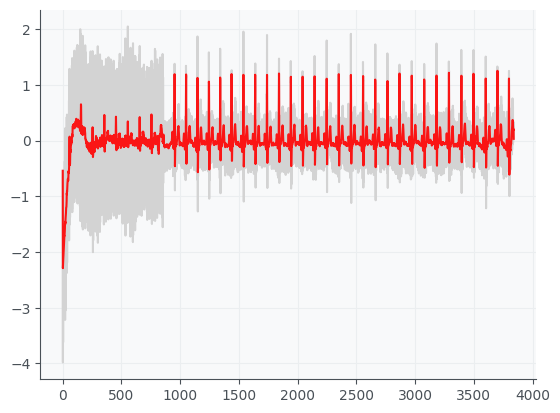

In [98]:
import neurokit2 as nk
import numpy as np

record = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
signals, info = nk.ecg_process(record, sampling_rate=fs, show = True)
rpeaks = info["ECG_R_Peaks"]
rpeak_amplitudes = ecg[rpeaks]


rri = get_rri(rpeaks, fs)

print("R-peak amplitudes:", rpeak_amplitudes)
print("QRS indices:", rpeaks)
print("R-R intervals (ms):", rri)



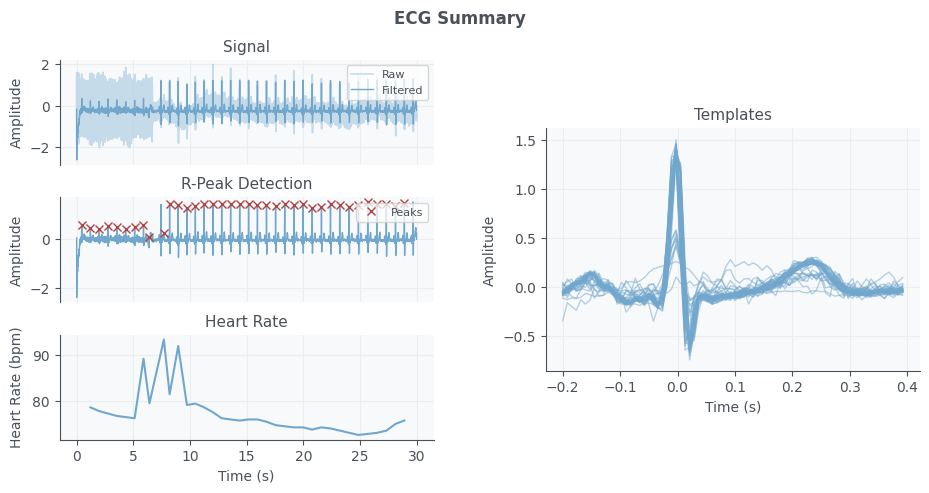

QRS Indices: [  58  155  254  354  453  554  655  755  822  985 1050 1147 1245 1341
 1437 1538 1638 1739 1841 1942 2042 2144 2247 2350 2453 2557 2660 2765
 2867 2971 3078 3182 3288 3394 3497 3601 3701]
R-R intervals (ms): [ 757.8125  773.4375  781.25    773.4375  789.0625  789.0625  781.25
  523.4375 1273.4375  507.8125  757.8125  765.625   750.      750.
  789.0625  781.25    789.0625  796.875   789.0625  781.25    796.875
  804.6875  804.6875  804.6875  812.5     804.6875  820.3125  796.875
  812.5     835.9375  812.5     828.125   828.125   804.6875  812.5
  781.25  ]


In [ ]:
from biosppy.signals import ecg
import numpy as np

record = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
out = ecg.ecg(signal=record, sampling_rate=fs, show=False)
rpeaks = out['rpeaks']
rri = get_rri(rpeaks, fs)
print("QRS Indices:", rpeaks)
print("R-R intervals (ms):", rri)

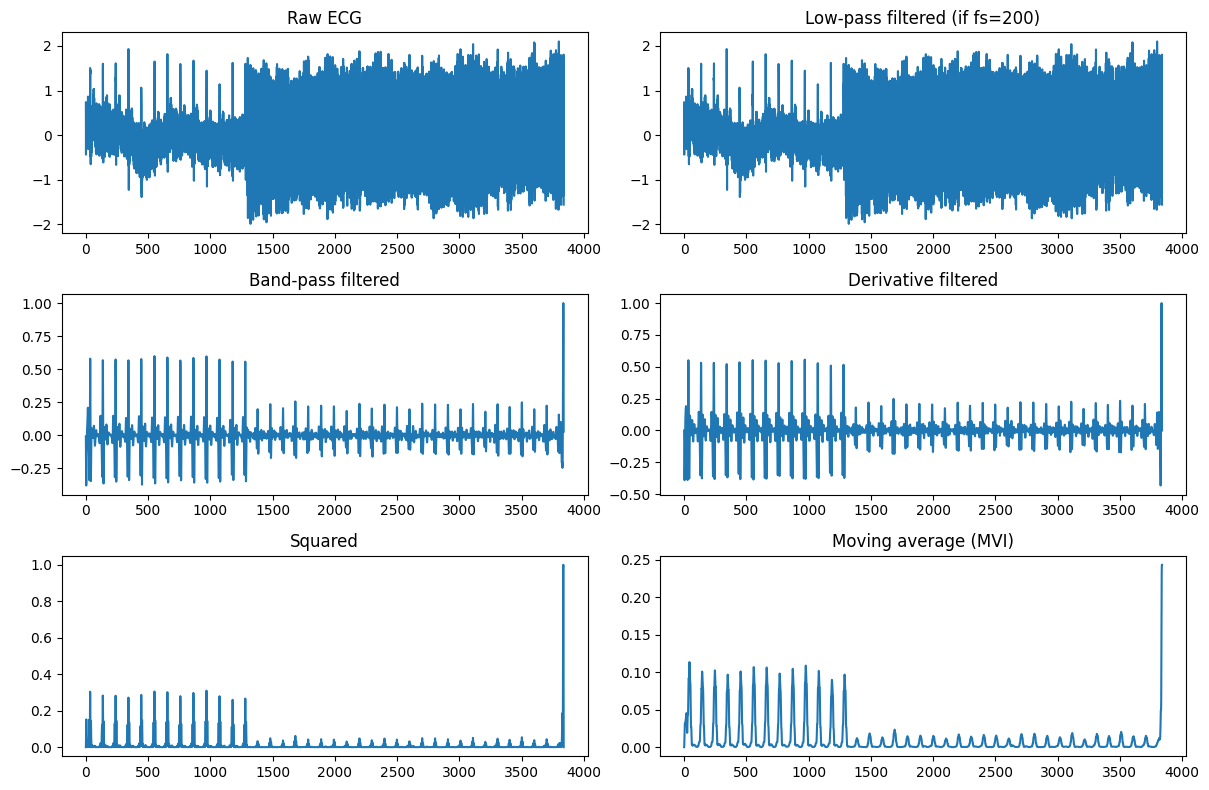

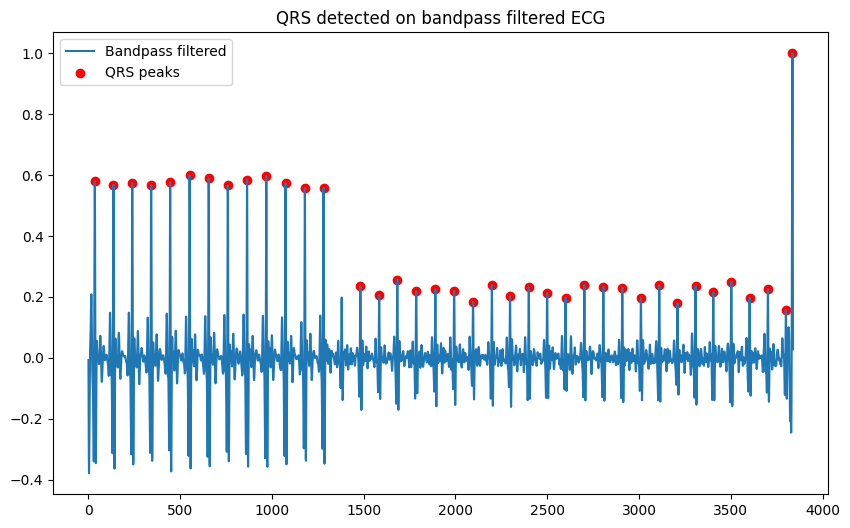

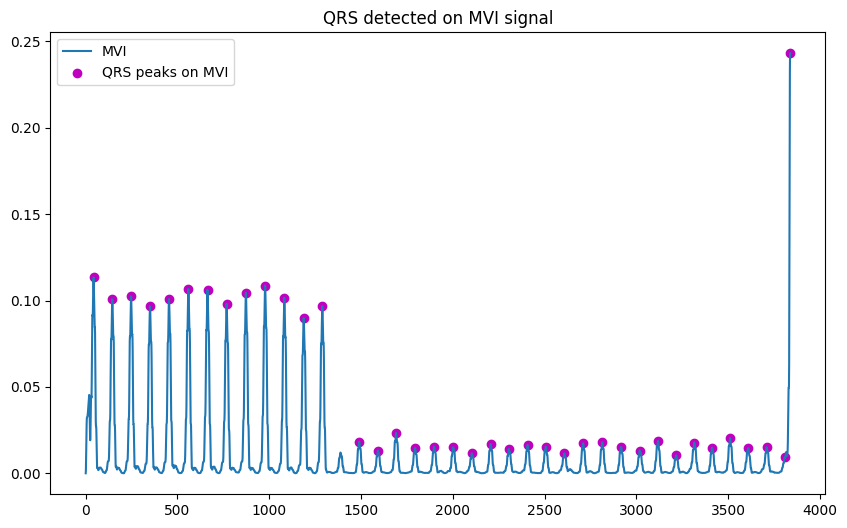

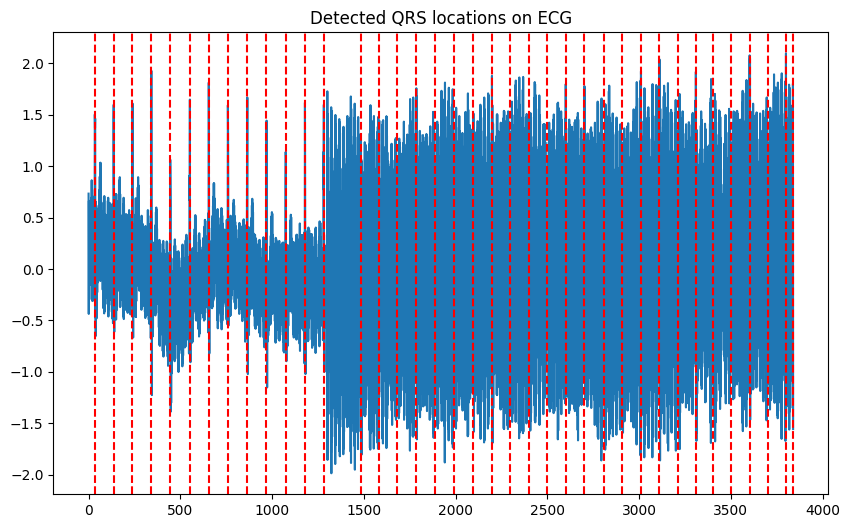

Detected 38 QRS complexes.
QRS Amplitudes: [ 1.095  1.19   0.95   1.65   0.785  0.39   1.535  1.315  0.855  0.65
  0.86   1.34   0.495  1.035  1.165 -0.245  1.48  -0.055  0.65  -0.86
  1.6    0.145 -0.615  0.215  1.52   1.5    0.005  0.87   1.645 -1.255
  0.125 -1.01   0.385  0.42  -1.135 -0.485  1.82   1.315]
QRS Indices: [  35  136  239  342  445  551  655  759  864  969 1074 1179 1281 1482
 1584 1683 1786 1890 1993 2096 2198 2297 2399 2499 2600 2702 2806 2909
 3010 3110 3209 3308 3405 3503 3603 3702 3800 3836]
Filtering delay (samples): 9


In [75]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, convolve

def pan_tompkins_matlab_style(ecg, fs, plot=False):
    
    import matplotlib.pyplot as plt
    raw_ecg = ecg  # Keep the original ECG for plotting later
    ecg = np.ravel(ecg)  # Ensure ecg is a 1D array
    delay = 0
    skip = False
    ser_back = False

    # === Remove mean of signal ===
    ecg = ecg - np.mean(ecg)

    # === Bandpass filtering ===
    if fs == 200:
        # Low-pass filter (approx 12 Hz cutoff)
        Wn_low = 12 * 2 / fs
        b_low, a_low = butter(3, Wn_low, btype='low')
        ecg_l = filtfilt(b_low, a_low, ecg)
        ecg_l /= np.max(np.abs(ecg_l))

        # High-pass filter (approx 5 Hz cutoff)
        Wn_high = 5 * 2 / fs
        b_high, a_high = butter(3, Wn_high, btype='high')
        ecg_h = filtfilt(b_high, a_high, ecg_l)
        ecg_h /= np.max(np.abs(ecg_h))

    else:
        # Bandpass filter 5-15 Hz for other sampling frequencies
        f1, f2 = 5, 15
        Wn = [f1 * 2 / fs, f2 * 2 / fs]
        b, a = butter(3, Wn, btype='bandpass')
        ecg_h = filtfilt(b, a, ecg)
        ecg_h /= np.max(np.abs(ecg_h))

    # === Derivative filter ===
    if fs == 200:
        b_deriv = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
    else:
        # interpolate for other fs (approximation)
        x_old = np.arange(5)
        y_old = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
        x_new = np.linspace(0, 4, int(fs / 40 * 4))  # approx scaling
        b_deriv = np.interp(x_new, x_old, y_old)
    ecg_d = filtfilt(b_deriv, [1], ecg_h)
    ecg_d /= np.max(np.abs(ecg_d))

    # === Squaring ===
    ecg_s = ecg_d ** 2

    # === Moving average window (150 ms) ===
    window_len = int(round(0.150 * fs))
    ecg_m = convolve(ecg_s, np.ones(window_len) / window_len, mode='full')[:len(ecg_s)]
    delay += int(window_len / 2)

    # === Find peaks in ecg_m (MVI signal) with min distance 200 ms ===
    min_distance = int(0.2 * fs)
    peaks, _ = find_peaks(ecg_m, distance=min_distance)

    # Initialize buffers and variables
    LLp = len(peaks)
    qrs_c = np.zeros(LLp)        # amplitudes of detected peaks in MVI signal
    qrs_i = np.zeros(LLp, dtype=int)  # indices of detected peaks in MVI
    qrs_i_raw = np.zeros(LLp, dtype=int)  # indices in filtered bandpass signal
    qrs_amp_raw = np.zeros(LLp)  # amplitudes in filtered bandpass signal

    nois_c = np.zeros(LLp)
    nois_i = np.zeros(LLp)
    SIGL_buf = np.zeros(LLp)
    NOISL_buf = np.zeros(LLp)
    SIGL_buf1 = np.zeros(LLp)
    NOISL_buf1 = np.zeros(LLp)
    THRS_buf = np.zeros(LLp)
    THRS_buf1 = np.zeros(LLp)

    THR_SIG = np.max(ecg_m[:2*fs]) / 3.0
    THR_NOISE = np.mean(ecg_m[:2*fs]) / 2.0
    SIG_LEV = THR_SIG
    NOISE_LEV = THR_NOISE

    THR_SIG1 = np.max(ecg_h[:2*fs]) / 3.0
    THR_NOISE1 = np.mean(ecg_h[:2*fs]) / 2.0
    SIG_LEV1 = THR_SIG1
    NOISE_LEV1 = THR_NOISE1

    Beat_C = 0
    Beat_C1 = 0
    Noise_Count = 0
    m_selected_RR = 0
    mean_RR = 0
    ser_back = False

    for i in range(LLp):
        loc = peaks[i]
        # find corresponding peak in filtered signal within 150 ms before peak
        window_start = max(loc - window_len, 0)
        window_end = loc
        if window_end > window_start:
            segment = ecg_h[window_start:window_end]
            y_i = np.max(segment)
            x_i = np.argmax(segment) + window_start
        else:
            y_i = ecg_h[loc]
            x_i = loc

        if Beat_C >= 9:
            diffRR = np.diff(qrs_i[Beat_C-8:Beat_C])
            mean_RR = np.mean(diffRR)
            comp = qrs_i[Beat_C-1] - qrs_i[Beat_C-2] if Beat_C > 1 else 0
            if comp != 0 and (comp <= 0.92 * mean_RR or comp >= 1.16 * mean_RR):
                THR_SIG *= 0.5
                THR_SIG1 *= 0.5
            else:
                m_selected_RR = mean_RR

        test_m = m_selected_RR if m_selected_RR != 0 else mean_RR if mean_RR != 0 else 0

        # Search back for missed QRS if gap > 1.66 * mean RR
        if test_m and Beat_C > 0:
            if (loc - qrs_i[Beat_C-1]) >= int(1.66 * test_m):
                search_segment = ecg_m[qrs_i[Beat_C-1] + int(0.2*fs):loc - int(0.2*fs)]
                if len(search_segment) > 0:
                    local_max = np.argmax(search_segment)
                    loc_temp = qrs_i[Beat_C-1] + int(0.2*fs) + local_max
                    pks_temp = search_segment[local_max]
                    if pks_temp > THR_NOISE:
                        Beat_C += 1
                        if Beat_C >= len(qrs_i):
                            break
                        qrs_c[Beat_C-1] = pks_temp
                        qrs_i[Beat_C-1] = loc_temp
                        # Bandpass filtered signal peak
                        w_start = max(loc_temp - window_len, 0)
                        w_end = min(loc_temp, len(ecg_h))
                        segment2 = ecg_h[w_start:w_end]
                        if len(segment2) > 0:
                            y_i_t = np.max(segment2)
                            x_i_t = np.argmax(segment2) + w_start
                            if y_i_t > THR_NOISE1:
                                Beat_C1 += 1
                                qrs_i_raw[Beat_C1-1] = x_i_t
                                qrs_amp_raw[Beat_C1-1] = y_i_t
                                SIG_LEV1 = 0.25 * y_i_t + 0.75 * SIG_LEV1
                        SIG_LEV = 0.25 * pks_temp + 0.75 * SIG_LEV

        # Threshold check
        if ecg_m[loc] >= THR_SIG:
            if Beat_C >= 3:
                if (loc - qrs_i[Beat_C-1]) <= int(0.360 * fs):
                    slope1 = np.mean(np.diff(ecg_m[loc - int(0.075 * fs):loc]))
                    slope2 = np.mean(np.diff(ecg_m[qrs_i[Beat_C-1] - int(0.075 * fs):qrs_i[Beat_C-1]]))
                    if np.abs(slope1) <= 0.5 * np.abs(slope2):
                        Noise_Count += 1
                        if Noise_Count < LLp:
                            nois_c[Noise_Count-1] = ecg_m[loc]
                            nois_i[Noise_Count-1] = loc
                        skip = True
                        NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
                        NOISE_LEV = 0.125 * ecg_m[loc] + 0.875 * NOISE_LEV
                    else:
                        skip = False
            if not skip:
                Beat_C += 1
                if Beat_C > LLp:
                    break
                qrs_c[Beat_C-1] = ecg_m[loc]
                qrs_i[Beat_C-1] = loc

                if y_i >= THR_SIG1:
                    Beat_C1 += 1
                    if Beat_C1 > LLp:
                        break
                    if ser_back:
                        qrs_i_raw[Beat_C1-1] = x_i
                    else:
                        qrs_i_raw[Beat_C1-1] = x_i
                    qrs_amp_raw[Beat_C1-1] = y_i
                    SIG_LEV1 = 0.125 * y_i + 0.875 * SIG_LEV1
                SIG_LEV = 0.125 * ecg_m[loc] + 0.875 * SIG_LEV
        elif THR_NOISE <= ecg_m[loc] < THR_SIG:
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_m[loc] + 0.875 * NOISE_LEV
        else:
            Noise_Count += 1
            if Noise_Count < LLp:
                nois_c[Noise_Count-1] = ecg_m[loc]
                nois_i[Noise_Count-1] = loc
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_m[loc] + 0.875 * NOISE_LEV

        # Update thresholds
        THR_SIG = NOISE_LEV + 0.25 * np.abs(SIG_LEV - NOISE_LEV)
        THR_NOISE = 0.5 * THR_SIG

        THR_SIG1 = NOISE_LEV1 + 0.25 * np.abs(SIG_LEV1 - NOISE_LEV1)
        THR_NOISE1 = 0.5 * THR_SIG1

        SIGL_buf[i] = SIG_LEV
        NOISL_buf[i] = NOISE_LEV
        THRS_buf[i] = THR_SIG

        SIGL_buf1[i] = SIG_LEV1
        NOISL_buf1[i] = NOISE_LEV1
        THRS_buf1[i] = THR_SIG1

        skip = False
        ser_back = False

    # Trim to detected beats
    qrs_i_raw = qrs_i_raw[:Beat_C1]
    qrs_amp_raw = qrs_amp_raw[:Beat_C1]
    qrs_c = qrs_c[:Beat_C]
    qrs_i = qrs_i[:Beat_C]

    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(12, 8))
        axs[0, 0].plot(ecg)
        axs[0, 0].set_title("Raw ECG")
        axs[0, 1].plot(ecg_l if fs == 200 else ecg)
        axs[0, 1].set_title("Low-pass filtered (if fs=200)")

        axs[1, 0].plot(ecg_h)
        axs[1, 0].set_title("Band-pass filtered")
        axs[1, 1].plot(ecg_d)
        axs[1, 1].set_title("Derivative filtered")

        axs[2, 0].plot(ecg_s)
        axs[2, 0].set_title("Squared")
        axs[2, 1].plot(ecg_m)
        axs[2, 1].set_title("Moving average (MVI)")

        plt.tight_layout()
        plt.show()

        # Plot QRS on filtered signals
        plt.figure(figsize=(10, 6))
        plt.plot(ecg_h, label="Bandpass filtered")
        plt.scatter(qrs_i_raw, qrs_amp_raw, color='r', label="QRS peaks")
        plt.legend()
        plt.title("QRS detected on bandpass filtered ECG")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg_m, label="MVI")
        plt.scatter(qrs_i, qrs_c, color='m', label="QRS peaks on MVI")
        plt.legend()
        plt.title("QRS detected on MVI signal")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg - np.mean(ecg), label="ECG centered")
        for peak in qrs_i_raw:
            plt.axvline(x=peak, color='r', linestyle='--')
        plt.title("Detected QRS locations on ECG")
        plt.show()

    return qrs_amp_raw, qrs_i_raw, delay

ecg = np.load(os.path.join(save_dir, 'p01_1.npy'))
fs = 128
qrs_amp_raw, qrs_i_raw, delay = pan_tompkins_matlab_style(ecg, fs, plot=True)
amps = ecg[qrs_i_raw]
print(f"Detected {len(qrs_i_raw)} QRS complexes.")
print("QRS Amplitudes:", amps)
print("QRS Indices:", qrs_i_raw)
print("Filtering delay (samples):", delay)

In [54]:
%pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [neurokit2]/2 [neurokit2]
Note: you may need to restart the kernel to use updated packages.


/Users/weijithwimalasiri/anaconda3/envs/harbor/lib/python3.13/site-packages/neurokit2/ecg/ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


R-peak amplitudes: [ 1.68   1.095  1.74   1.21   1.35   1.6    1.1    1.705  1.685  0.86
  1.415  0.865  1.635  1.465  1.08   0.895  1.765  1.645  1.555  1.64
  1.64   1.91   1.305  0.935  1.02   1.4    1.21   1.195  0.65  -0.43
  0.56   1.22   1.435  0.715  0.385  0.55   0.78   1.58   1.095  1.32
  0.95   1.65   0.57   0.39   1.535  1.035  1.39   0.65   0.86   1.34
  0.495 -0.115  1.035  1.165 -0.245  1.48  -0.005  0.65  -0.86  -1.025
  0.04  -0.615  0.355  1.52  -1.055  0.005  0.87  -1.315  1.76   0.5
 -1.01   0.385  0.42  -1.135  0.95   1.82  -0.78   1.21   1.59  -0.29
 -0.5    1.86   1.525 -0.595 -0.89   0.035  0.92   1.355  1.04   1.425
  1.23   2.     1.275  1.82   1.295  0.81   0.98   1.22   0.59 ]
QRS indices: [  51  154  257  359  463  568  672  778  883  989 1095 1199 1305 1409
 1510 1606 1706 1803 1900 1999 2096 2196 2297 2399 2501 2602 2702 2800
 2887 2975 3091 3186 3284 3381 3478 3575 3675 3774 3875 3977 4079 4182
 4286 4391 4495 4600 4705 4809 4914 5019 5121 5220 5322 542

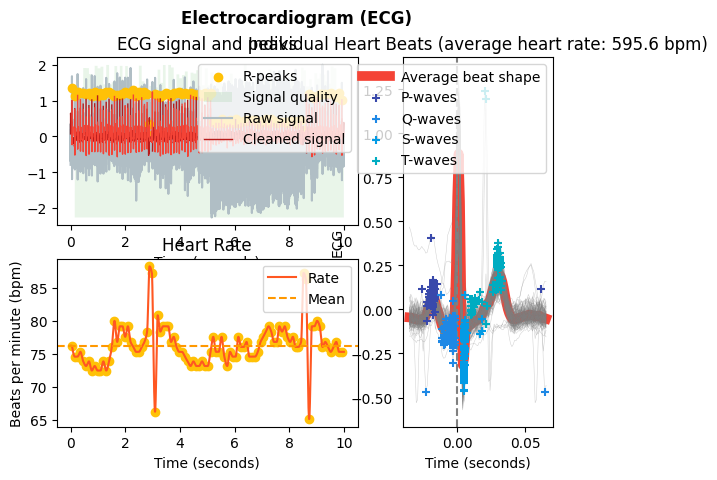

In [60]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import wfdb
# Load your ECG signal (assuming ecg is 1D NumPy array)
record_path = '/Users/weijithwimalasiri/Desktop/JustForFun/RPS/physionet.org/files/afpdb/1.0.0/p01'
ecg = wfdb.rdrecord(record_path, sampto=10000)  # Load first 10 seconds for testing
annotation = wfdb.rdann(record_path, 'qrs', sampto=10000)  # Load annotations
ecg = ecg.p_signal[:, 0]  # Assuming the first channel is the
fs = annotation.fs  # Sampling frequency from the annotation file
# ecg = np.load('/Users/weijithwimalasiri/Desktop/JustForFun/RPS/physionet.org/files/afpdb/1.0.0/segments/p01_2.npy')  # or wherever your signal is

# Process ECG
signals, info = nk.ecg_process(ecg, sampling_rate=fs)

# Plot the results
nk.ecg_plot(signals)
# Access QRS peak indices
rpeaks = info["ECG_R_Peaks"]
rpeak_amplitudes = ecg[rpeaks]

print("R-peak amplitudes:", rpeak_amplitudes)
print("QRS indices:", rpeaks)


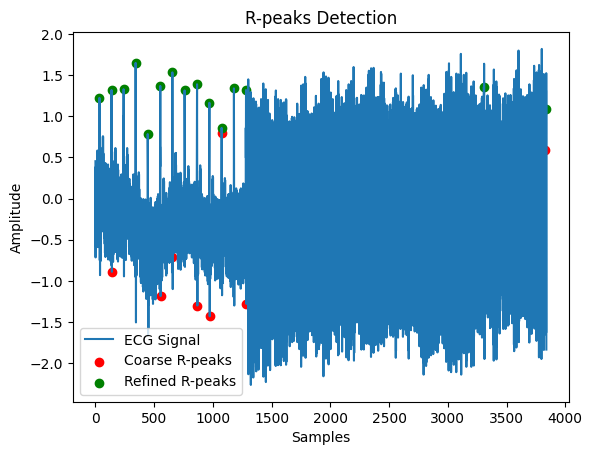

In [53]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def bandpass_filter(signal, fs):
    # Low-pass filter (cutoff 11 Hz)
    b_lp, a_lp = butter(1, 11 / (0.5 * fs), btype='low')
    low_passed = filtfilt(b_lp, a_lp, signal)

    # High-pass filter (cutoff 5 Hz)
    b_hp, a_hp = butter(1, 5 / (0.5 * fs), btype='high')
    bandpassed = filtfilt(b_hp, a_hp, low_passed)

    return bandpassed

def pan_tompkins_t(ecg, fs):
    ecg = ecg - np.mean(ecg)
    filtered = bandpass_filter(ecg, fs)

    h = np.array([1, 2, 0, -2, -1]) * (fs / 8.0)
    diff = np.convolve(filtered, h, mode='same')
    squared = diff ** 2
    window_size = int(0.150 * fs)
    mwa = np.convolve(squared, np.ones(window_size) / window_size, mode='same')

    min_distance = int(0.2 * fs)
    peaks, _ = find_peaks(mwa, distance=min_distance)

    sig_lev = np.max(mwa[:2 * fs]) * 0.25
    noise_lev = np.max(mwa[:2 * fs]) * 0.5
    threshold = noise_lev + 0.25 * (sig_lev - noise_lev)

    qrs_peaks, rr_intervals = [], []
    recent_rr, last_qrs = 0, -fs

    for i in peaks:
        peak_val = mwa[i]
        if peak_val > threshold:
            if qrs_peaks:
                slope1 = np.max(diff[qrs_peaks[-1] - 10:qrs_peaks[-1] + 10])
                slope2 = np.max(diff[i - 10:i + 10])
                if slope2 < 0.5 * slope1:
                    noise_lev = 0.125 * peak_val + 0.875 * noise_lev
                    threshold = noise_lev + 0.25 * (sig_lev - noise_lev)
                    continue
            qrs_peaks.append(i)
            sig_lev = 0.25 * peak_val + 0.75 * sig_lev
            if len(qrs_peaks) > 1:
                rr = i - qrs_peaks[-2]
                rr_intervals.append(rr)
                if len(rr_intervals) >= 8:
                    recent_rr = np.mean(rr_intervals[-8:])
        else:
            noise_lev = 0.125 * peak_val + 0.875 * noise_lev

        threshold = noise_lev + 0.25 * (sig_lev - noise_lev)

    if len(qrs_peaks) > 1 and recent_rr > 0:
        missed = []
        for j in range(len(qrs_peaks) - 1):
            rr_gap = qrs_peaks[j + 1] - qrs_peaks[j]
            if rr_gap > 1.66 * recent_rr:
                seg = mwa[qrs_peaks[j] + int(0.2 * fs):qrs_peaks[j + 1] - int(0.2 * fs)]
                local_max = np.argmax(seg)
                missed_peak = qrs_peaks[j] + int(0.2 * fs) + local_max
                missed.append(missed_peak)
        qrs_peaks.extend(missed)
        qrs_peaks = sorted(qrs_peaks)

    return np.array(qrs_peaks)

def refine_r_peaks(original_ecg, coarse_peaks, fs, window_ms=100):
    refined_peaks = []
    half_window = int((window_ms / 1000) * fs / 2)
    for peak in coarse_peaks:
        start = max(0, peak - half_window)
        end = min(len(original_ecg), peak + half_window)
        refined = start + np.argmax(original_ecg[start:end])
        refined_peaks.append(refined)
    return np.array(refined_peaks)

ecg = np.load(os.path.join(save_dir, 'p01_1.npy'))
fs = 128
coarse_peaks = pan_tompkins_t(ecg, fs)

refined_peaks = refine_r_peaks(ecg, coarse_peaks, fs)

plt.plot(ecg, label='ECG Signal')
plt.scatter(coarse_peaks, ecg[coarse_peaks], color='red', label='Coarse R-peaks')
plt.scatter(refined_peaks, ecg[refined_peaks], color='green', label='Refined R-peaks')
plt.title('R-peaks Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()